In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..', 'module'))

In [3]:
import wiki

path_base = '/Users/harangju/Developer/data/wiki/dumps/'
name_xml = 'enwiki-20190801-pages-articles-multistream.xml.bz2'
name_index = 'enwiki-20190801-pages-articles-multistream-index.txt.bz2'
path_xml = path_base + name_xml
path_index = path_base + name_index
dump = wiki.Dump(path_xml, path_index)

In [4]:
topic = 'evolutionary biology'
%time dump.load_page('Index of {} articles'.format(topic))
links = dump.links
dump.links[:5]

Dump: Loading index...
Dump: Loaded.
CPU times: user 1min 19s, sys: 2.17 s, total: 1min 21s
Wall time: 1min 21s


['File:charles Darwin by Julia Margaret Cameron 2.jpg',
 'Charles Darwin',
 'Evolutionary biology',
 'The Origin of Species',
 'Abiogenesis']

In [5]:
net = wiki.Net()
net.build_graph(name=topic, dump=dump, nodes=[str(l) for l in links],
                compute_core_periphery=False, compute_communities=False)

wiki.Net: traversing Wikipedia...
wiki.Net: depth = 0
wiki.Net: len(queue) = 160
wiki.Net: depth = 1
wiki.Net: removing isolates...
wiki.Net: adding years...
wiki.Net: filling empty years...


In [6]:
net.graph.nodes['Darwinism']

{'year': 1800}

In [7]:
[len(links), len(net.graph.nodes)]
# [291, 265] with redirects
# [291, 234] without

[291, 265]

In [8]:
[len(links), len(net.graph.nodes)]

[291, 265]

#### Test network generation

In [9]:
import pickle
import gensim.utils as gu

path_save = '/Users/harangju/Developer/data/wiki/models/'
tfidf = gu.SaveLoad.load(path_save + 'tfidf.model')
dct = pickle.load(open(path_save + 'dict.model','rb'))

In [10]:
net = wiki.Net()
net.build_graph(name=topic, dump=dump, nodes=[str(l) for l in links],
                model=tfidf, dct=dct)

wiki.Net: traversing Wikipedia...
wiki.Net: depth = 0
wiki.Net: len(queue) = 160
wiki.Net: depth = 1
wiki.Net: removing isolates...
wiki.Net: adding years...
wiki.Net: filling empty years...
wiki.Net: calculating weights...
wiki.Net: computing core-periphery...
wiki.Net: computing communities...


In [11]:
[len(links), len(net.graph.nodes)]
# [291, 265] with redirects
# [291, 234] without

[291, 265]

In [12]:
net.save_graph(topic)

In [13]:
new_net = wiki.Net()
new_net.load_graph(topic)
len(new_net.graph.nodes)

265

In [14]:
new_net.graph.graph

{'name': 'evolutionary biology',
 'tfidf': <2080851x265 sparse matrix of type '<class 'numpy.float64'>'
 	with 253947 stored elements in Compressed Sparse Column format>,
 'coreness': 0.7845415242880858,
 'modularity': 0.26006018498783096}

In [15]:
[n for n in net.graph.nodes][:5]

['The Voyage of the Beagle',
 'Charles Darwin',
 'Charles Lyell',
 'Thomas Henry Huxley',
 'Evolution']

In [16]:
[y for y in net.years][:5]

[-9000, -3500, -1900, -600, -500]

In [17]:
net._numbered = None
[n for n in net.numbered.nodes][:5]

[0, 1, 36, 23, 85]

#### Test weighting with tf-idf model

In [18]:
net.graph['Evolution']

AtlasView({'Charles Darwin': {'weight': 0.4313447568679566}, 'Evolutionary biology': {'weight': 0.4400523916182571}, 'The Origin of Species': {'weight': 0.5765181173462256}, 'Adaptation': {'weight': 0.6818558586652332}, 'Anti-predator adaptation': {'weight': 0.3528309736849022}, 'Archaeopteryx': {'weight': 0.27985701037935673}, 'Atavism': {'weight': 0.38007029772108963}, 'Gene-centered view of evolution': {'weight': 0.564823956705098}, 'Cephalization': {'weight': 0.29803593027631003}, 'Chronospecies': {'weight': 0.3264603555788205}, 'Co-evolution': {'weight': 0.435903518311745}, 'Co-operation (evolution)': {'weight': 0.5113070391815111}, 'Common descent': {'weight': 0.5480997893873277}, 'Convergent evolution': {'weight': 0.49094971306719426}, 'Creation-evolution controversy': {'weight': 0.5432976990825654}, 'Darwin (unit)': {'weight': 0.4049276501924059}, 'Darwinism': {'weight': 0.4040596533555473}, 'Directed mutagenesis': {'weight': 0.31889300576344215}, 'Directed evolution': {'weight

In [19]:
net.graph['Transposon']

AtlasView({'List of biology topics': {'weight': 0.1966936076996275}})

#### Test coreness

In [20]:
net.graph.graph['coreness']

0.7845415242880858

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

matrix = nx.convert_matrix.to_numpy_array(net.graph,
                                          nodelist=[n for n in net.graph.nodes
                                                    if net.graph.nodes[n]['core']] +
                                                   [n for n in net.graph.nodes
                                                    if not net.graph.nodes[n]['core']])
plt.imshow(matrix)

/Users/harangju/anaconda3/envs/wikinet/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/harangju/anaconda3/envs/wikinet/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


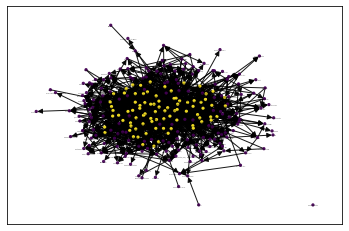

In [23]:
import networkx as nx
pos = nx.drawing.nx_agraph.graphviz_layout(net.graph, prog='neato')
nx.drawing.nx_pylab.draw_networkx(net.graph,
                                  pos,
                                  font_size=0,
                                  alpha=0.9,
                                  node_size=5,
                                  node_color=[net.graph.nodes[n]['core']
                                              for n in net.graph.nodes])

#### Test community structure

In [24]:
net.graph.graph['modularity']

0.26006018498783096

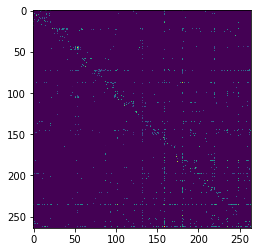

In [25]:
import matplotlib.pyplot as plt

num_communities = max([net.graph.nodes[n]['community'] for n in net.graph.nodes])
nodelist = [[n for n in net.graph.nodes if net.graph.nodes[n]['community']==i]
            for i in range(num_communities)]
nodelist = [n for ns in nodelist for n in ns]
matrix = nx.convert_matrix.to_numpy_array(net.graph,
                                          nodelist=nodelist)
plt.imshow(matrix)

#### Test clique to barcodes

In [26]:
net._cliques = None
%time net.cliques[:4]
%time net.cliques[:4]

CPU times: user 25.5 ms, sys: 965 µs, total: 26.4 ms
Wall time: 26.3 ms
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 5.72 µs


[[0], [1], [36], [23]]

In [29]:
net.nodes_for_year[1800]

[3,
 5,
 10,
 22,
 23,
 32,
 50,
 63,
 70,
 80,
 105,
 115,
 134,
 152,
 183,
 188,
 237,
 240,
 242,
 258]

In [30]:
%time net.filtration

CPU times: user 3.67 s, sys: 13.4 ms, total: 3.68 s
Wall time: 3.69 s


Filtration with 8797 simplices

In [31]:
%time net.persistence

CPU times: user 5.98 ms, sys: 110 µs, total: 6.09 ms
Wall time: 6.09 ms


Reduced matrix with 8797 columns

In [32]:
import pandas as pd
pd.options.display.max_rows = 12

In [33]:
net._barcodes = None
%time net.barcodes
%time net.barcodes

wiki.Net: computing barcodes... (skip negatives)
wiki.Net: barcode 8788/8797
CPU times: user 3.13 s, sys: 768 ms, total: 3.9 s
Wall time: 4.23 s
CPU times: user 14 µs, sys: 3 µs, total: 17 µs
Wall time: 19.1 µs


,dim,birth,death,lifetime,birth simplex,death simplex,birth nodes,death nodes,homology nodes
0,0,-9000,inf,inf,[Domestication],[],[Domestication],[],[]
1,0,-3500,-3500.0,0.0,[Domestication of the horse],"[Domestication, Domestication of the horse]",[Domestication of the horse],[Domestication of the horse],"[Domestication of the horse, Domestication]"
2,0,-1900,1600.0,3500.0,[Language],"[Evolution, Domestication]",[Language],[Evolution],"[Domestication, Language]"
3,0,-600,-600.0,0.0,[Origin of language],"[Origin of language, Language]",[Origin of language],[Origin of language],"[Origin of language, Language]"
4,0,-500,1600.0,2100.0,[Phylogenetics],"[Evolution, Human evolution]",[Phylogenetics],[Evolution],"[Origin of language, Phylogenetics]"
...,...,...,...,...,...,...,...,...,...
4462,6,1915,1915.0,0.0,"[Natural selection, Evolutionary biology, Hist...","[Evolution, Natural selection, Evolutionary bi...",[J. B. S. Haldane],[J. B. S. Haldane],"[Natural selection, History of evolutionary th..."
4463,6,1915,1915.0,0.0,"[Modern synthesis (20th century), Evolutionary...","[Evolution, Modern synthesis (20th century), E...",[J. B. S. Haldane],[J. B. S. Haldane],"[Modern synthesis (20th century), History of e..."
4464,6,1915,1915.0,0.0,"[Modern synthesis (20th century), Evolutionary...","[Evolution, Modern synthesis (20th century), E...",[J. B. S. Haldane],[J. B. S. Haldane],"[Modern synthesis (20th century), History of e..."
4465,7,1915,1915.0,0.0,"[Natural selection, Modern synthesis (20th cen...","[Evolution, Natural selection, Modern synthesi...",[J. B. S. Haldane],[J. B. S. Haldane],"[Natural selection, Modern synthesis (20th cen..."


In [34]:
net.barcodes[net.barcodes.lifetime!=0]

,dim,birth,death,lifetime,birth simplex,death simplex,birth nodes,death nodes,homology nodes
0,0,-9000,inf,inf,[Domestication],[],[Domestication],[],[]
2,0,-1900,1600.0,3500.0,[Language],"[Evolution, Domestication]",[Language],[Evolution],"[Domestication, Language]"
4,0,-500,1600.0,2100.0,[Phylogenetics],"[Evolution, Human evolution]",[Phylogenetics],[Evolution],"[Origin of language, Phylogenetics]"
5,0,-458,1600.0,2058.0,[Heredity],"[Evolution, Heredity]",[Heredity],[Evolution],"[Phylogenetics, Heredity]"
6,0,-350,1600.0,1950.0,[Anti-predator adaptation],"[Evolution, Anti-predator adaptation]",[Anti-predator adaptation],[Evolution],"[Phylogenetics, Anti-predator adaptation]"
...,...,...,...,...,...,...,...,...,...
2764,2,2020,inf,inf,"[Systematics, Phylogenetic tree, Evolutionary ...",[],[Systematics],[],[]
2765,2,2020,inf,inf,"[Systematics, History of speciation, List of b...",[],[Systematics],[],[]
2767,2,2020,inf,inf,"[Systematics, Joe Felsenstein, Molecular syste...",[],[Systematics],[],[]
2770,2,2020,inf,inf,"[History of evolutionary thought, Jean-baptist...",[],[Jean-baptiste Lamarck],[],[]
